<a href="https://colab.research.google.com/github/ShleshaPandey/Face_similarity_with-siamese_in_Pytorch/blob/main/Train_deepNN_for_ImageRepresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import PIL.ImageOps
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from scipy.spatial.distance import cdist
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle
from sklearn.cluster import KMeans
import os
import sys
torch.manual_seed(42)

In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy() # channel, hight, width = (0, 1, 2)
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (1, 2, 0) = channel last notation
    plt.show()

In [ ]:
 def show_plot(iteration,loss):
    plt.plot(iteration, loss)
    plt.show()

### Configuration class

In [ ]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"

    train_batch_size = 4
    train_number_epochs = 60

### Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
class SiameseNetworkDataset(Dataset):

    # this is invoked when the object is created
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    # this is invoked when you loop through the datasets / iterating
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #27
        #print("anchor image ", img0_tuple)

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)            # 0 = genuine  &  1 = imposter

        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) #27
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:)
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        label = torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

        return img0, img1 , label

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

#### Using Image Folder Dataset

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

### Visualising the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)

In [ ]:
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)

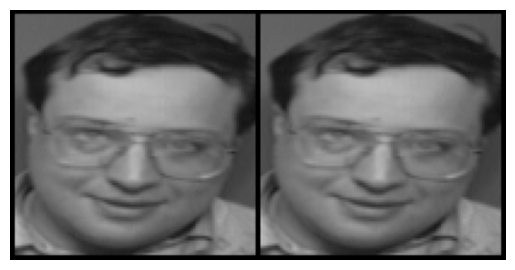

[[0.]]


In [ ]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),  #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 512)                             #extracting 512 features per image
            )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)                                      # flattening
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def representations(self,inp):                      #defining a  method to process only one image through the model , in order to get its feature
        rep = self.forward_once(inp)
        return rep

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

#### **Loading the data for training**

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,                                                                  # shuffle = False will make it sequential
                        num_workers=4,
                        batch_size=Config.train_batch_size)

**Calling the model class**

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001 )

In [ ]:
counter = []
loss_history = []
iteration_number= 0

### **Training our model**

Epoch number 0
 Current loss 0.9574626088142395

Epoch number 0
 Current loss 6.970931053161621

Epoch number 0
 Current loss 11.934889793395996

Epoch number 0
 Current loss 29.06784439086914

Epoch number 0
 Current loss 0.9577022194862366

Epoch number 0
 Current loss 153.54185485839844

Epoch number 0
 Current loss 0.0

Epoch number 0
 Current loss 128.1968994140625

Epoch number 0
 Current loss 6.858208179473877

Epoch number 0
 Current loss 23.2667293548584

Epoch number 1
 Current loss 3.927943706512451

Epoch number 1
 Current loss 1.5434441566467285

Epoch number 1
 Current loss 16.083847045898438

Epoch number 1
 Current loss 1.452215552330017

Epoch number 1
 Current loss 1.8292267322540283

Epoch number 1
 Current loss 2.8890223503112793

Epoch number 1
 Current loss 28.751787185668945

Epoch number 1
 Current loss 0.2995953857898712

Epoch number 1
 Current loss 0.5952125787734985

Epoch number 1
 Current loss 5.240316390991211

Epoch number 2
 Current loss 0.1596883088350

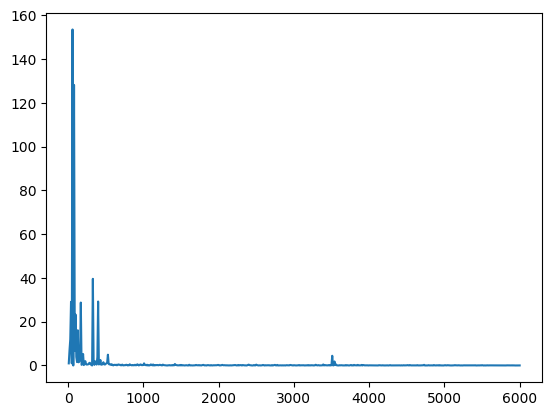

In [ ]:
#training
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

        optimizer.zero_grad()
        output1,output2 = net(img0,img1)                            #forward method is invoked
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

### **Testing our model's efficiency**
The Distance between each image pair denotes the degree of similarity the model found between the two images. The number over the pairs denoted the level of
Dissimilarity between the images. Lesser means it found lesser dissimilar ( or more similar), while higher values indicate it found them to be  highly dissimilar.

So we can put some threshold value to mark whethe a image-pair belongs to same person or different. For e.g., here we see that images of same person is having a dissimilarity index below 1 so for this case 1 can be a threshold value.

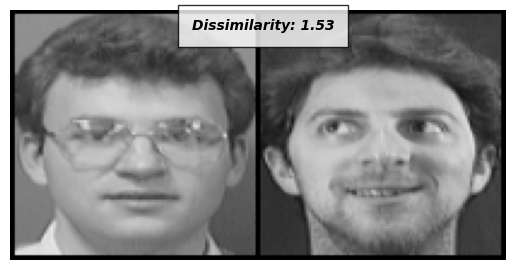

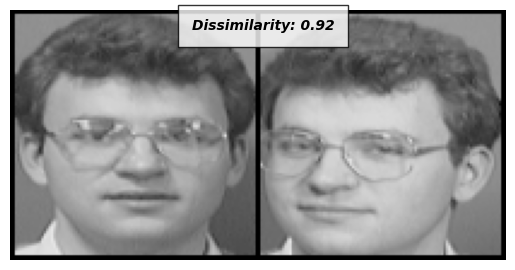

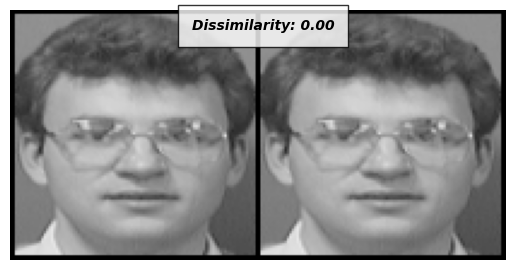

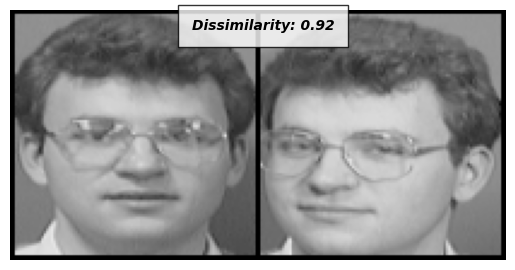

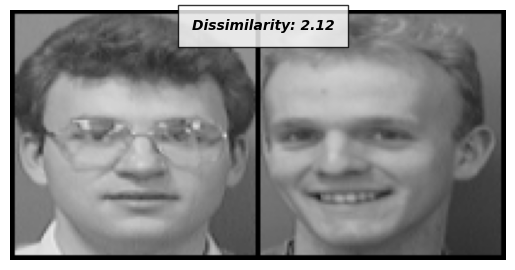

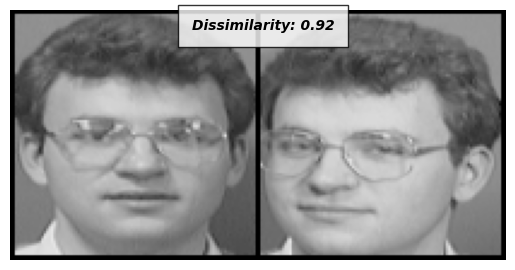

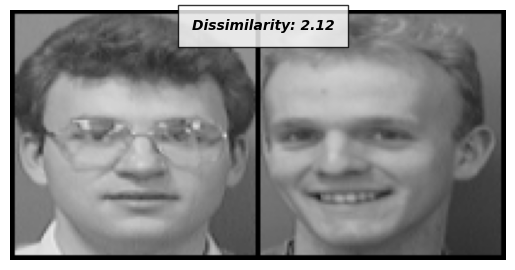

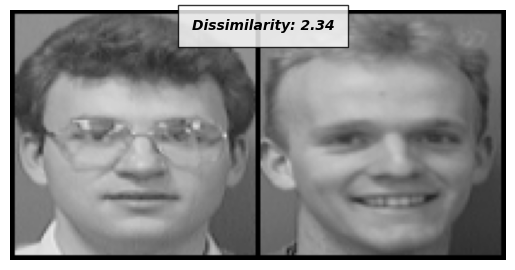

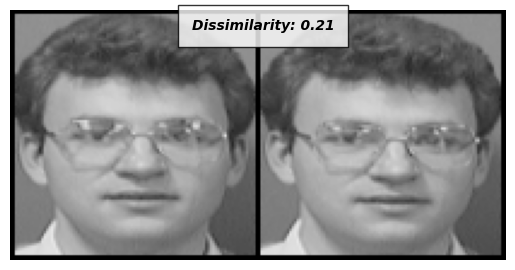

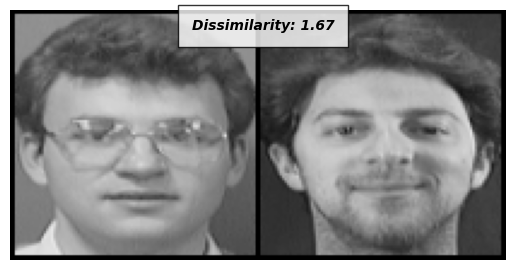

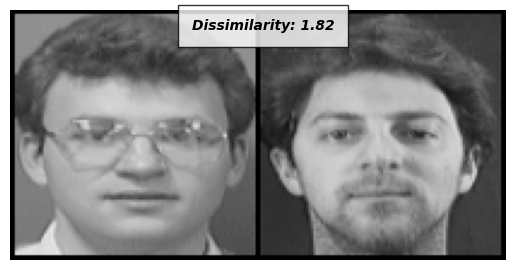

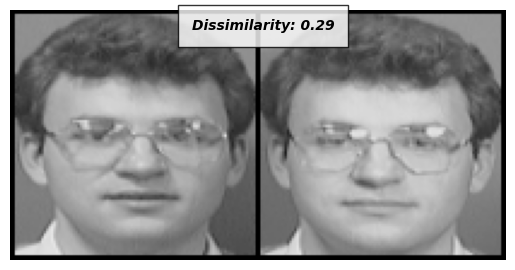

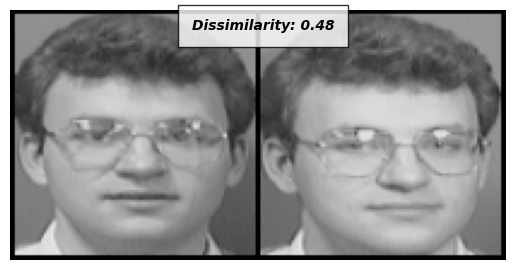

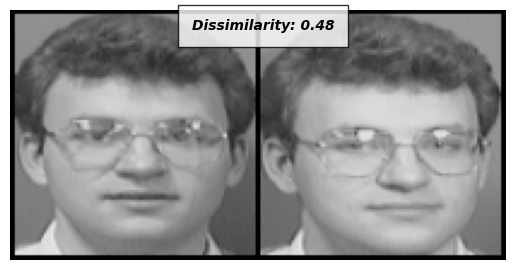

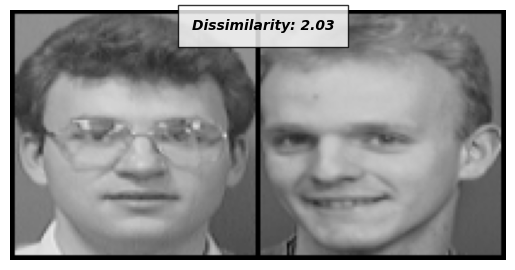

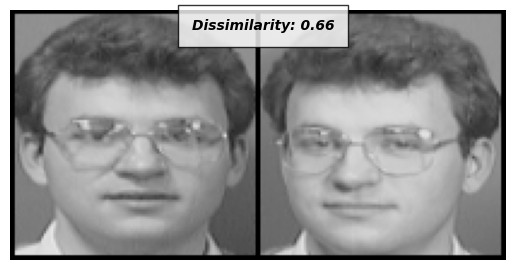

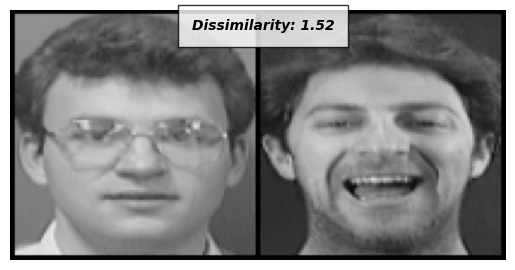

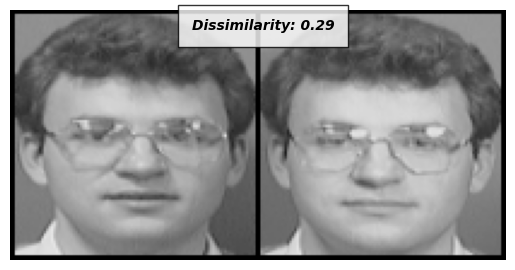

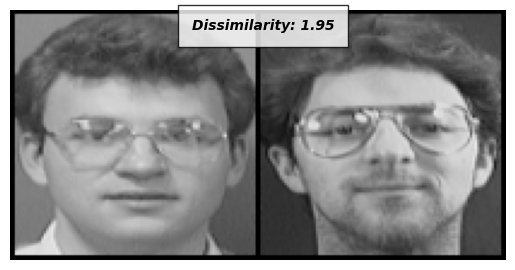

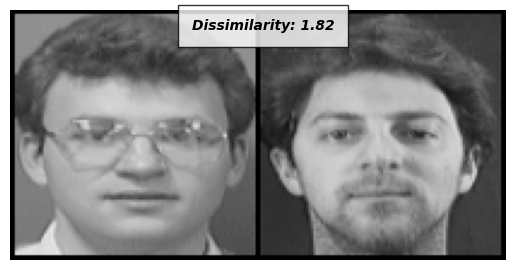

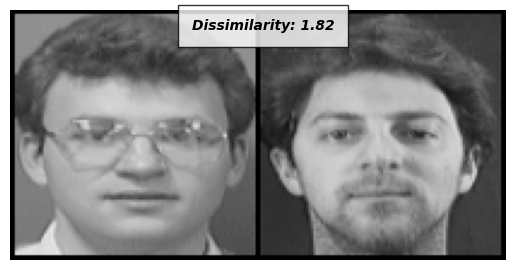

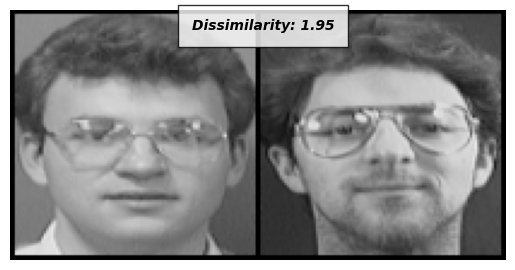

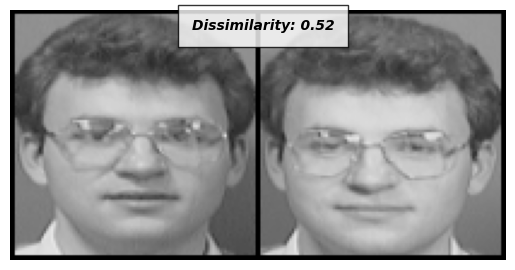

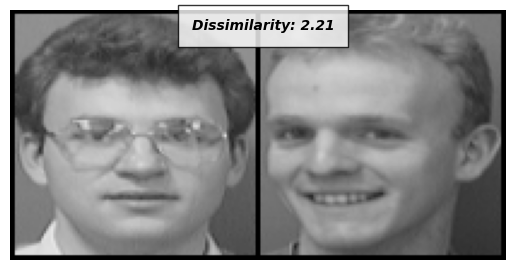

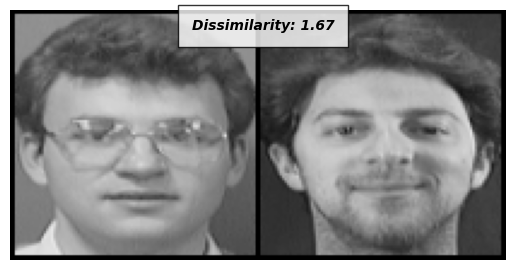

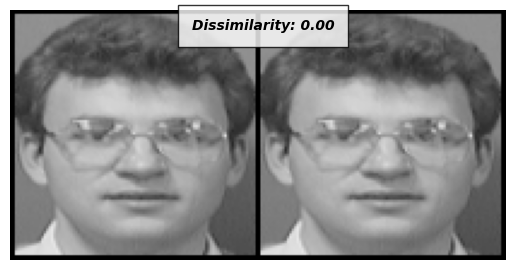

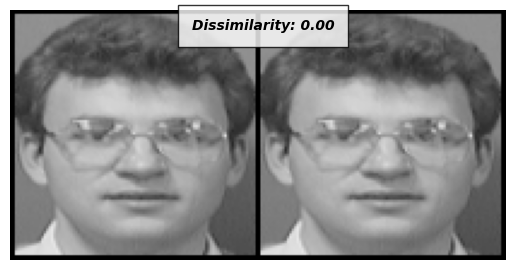

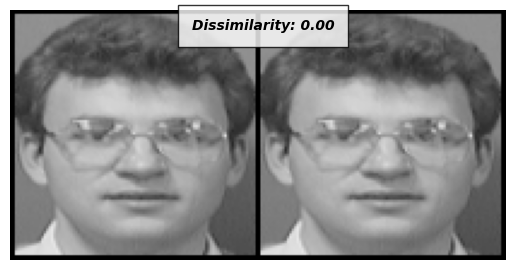

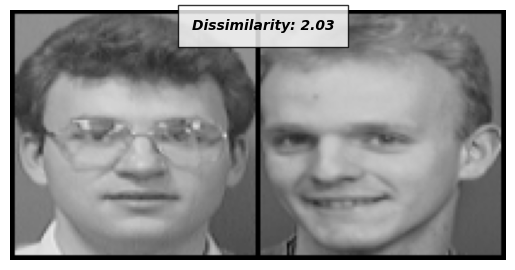

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=4,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(29):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2) #similarity metric
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))


## **Saving the Neural network model**

In [ ]:
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('model_scripted_image_dissimilarity.pt') # Save

### **Extracting the fetaures of every image by applying the model. And Saving those features**

In [ ]:
img_file_list=[]
img_file_list = [x for x in folder_dataset.imgs]                   # folder_dataset contains training image folders
for x in folder_dataset_test.imgs:                                   # folder_dataset_test contains testing image folders
  img_file_list.append(x)

transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])

feat = []                      # saving features of last epoch
img_cls = []
path_img = []

for y in img_file_list:                                                                                        #  img_file_list ----->>    compare
    check_img  =  Image.open(y[0])
    ch_img = check_img.convert("L")
    ch_img = transform(ch_img)
   # img0_us = torch.unsqueeze(img0,0)
    ch_img_us =torch.unsqueeze(ch_img,0)
    output = net.representations(Variable(ch_img_us).cuda())  # applying the nn model to get the features of images

    ch_img_features = output.cpu().detach().numpy()
    feat.append(ch_img_features)
    img_cls.append(y[0].split('/')[-2] )       # list containig the class of image
    path_img.append(y[0])                                 # list containing image file path


## **Get the representations of all the training and testing images (all 400 images)**

In [ ]:
feat_arr =  np.asarray(feat)
# reshaping array 3d to 2d
feat_arr = np.reshape(feat,(-1,512))
image_data = pd.DataFrame(feat_arr)
image_data['Path_of_images'] = path_img   # saving path os image for our references to the images, it's a kind of marking for our understanding

In [ ]:
image_data

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,Path_of_images
0,-0.065484,-0.198737,-0.199418,0.114269,0.173315,-0.096728,-0.215508,-0.042840,0.016435,0.052884,...,0.005581,-0.005867,0.066939,0.169838,0.231526,0.062305,-0.064795,0.050288,-0.008166,./data/faces/training/s1/1.pgm
1,-0.080641,-0.281770,-0.180255,0.095576,0.237762,-0.068946,-0.252538,-0.098618,0.019732,0.003291,...,0.025195,-0.006661,0.091195,0.227989,0.261830,0.136935,-0.078530,0.056640,0.025685,./data/faces/training/s1/10.pgm
2,-0.028802,-0.213326,-0.172072,0.067763,0.211298,-0.059016,-0.150049,-0.052285,0.033694,0.003840,...,0.042645,0.023047,0.029993,0.190257,0.223093,0.130520,-0.024610,0.008595,0.021879,./data/faces/training/s1/2.pgm
3,-0.095770,-0.250584,-0.213074,0.114058,0.202594,-0.030233,-0.242624,-0.090372,0.008712,0.013139,...,0.007603,-0.047810,0.070641,0.225976,0.199982,0.111013,-0.021050,0.033599,0.000444,./data/faces/training/s1/3.pgm
4,-0.096621,-0.255218,-0.244679,0.120552,0.237801,-0.043914,-0.246177,-0.071979,0.024472,0.016160,...,0.024179,-0.035721,0.074748,0.218086,0.231211,0.116214,-0.018800,0.036765,-0.018340,./data/faces/training/s1/4.pgm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.025860,-0.323806,-0.132407,0.054511,0.237767,-0.025173,-0.228399,-0.034220,0.060791,-0.008865,...,0.113185,0.042702,0.098197,0.221916,0.257906,0.209140,-0.093137,-0.012909,0.048509,./data/faces/testing/s7/5.pgm
396,-0.019794,-0.341871,-0.170614,0.071365,0.232370,-0.023430,-0.245667,0.017427,0.082846,0.020109,...,0.154681,0.053829,0.112149,0.224039,0.274369,0.213080,-0.088039,-0.047950,0.030823,./data/faces/testing/s7/6.pgm
397,-0.009257,-0.320637,-0.189308,0.068724,0.244788,-0.041504,-0.213238,0.021553,0.086440,0.020932,...,0.154504,0.066805,0.090627,0.219980,0.288178,0.206565,-0.067907,-0.051703,0.026825,./data/faces/testing/s7/7.pgm
398,-0.025541,-0.356320,-0.182202,0.069780,0.260695,-0.036838,-0.244050,-0.011018,0.079715,0.007677,...,0.150050,0.057709,0.107897,0.248966,0.300962,0.225250,-0.081877,-0.039161,0.041926,./data/faces/testing/s7/8.pgm


### **Saving only the feature representations into a csv file**

In [ ]:
# save dataframe to csv file
image_data.to_csv('image_512Featuresextracted.csv', index =False)                   # making a csv file containing all the 512 features of all 400 image samples in the Test-set

## **Loading the csv file and applying clustering technique on top of the features**

In [ ]:
image_data.iloc[:,:256]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.065484,-0.198737,-0.199418,0.114269,0.173315,-0.096728,-0.215508,-0.042840,0.016435,0.052884,...,-0.015731,0.103744,0.185493,0.124592,-0.142863,0.089805,-0.035695,-0.218372,-0.012124,0.013920
1,-0.080641,-0.281770,-0.180255,0.095576,0.237762,-0.068946,-0.252538,-0.098618,0.019732,0.003291,...,-0.009416,0.155778,0.229824,0.083133,-0.152488,0.108208,-0.018638,-0.227824,-0.004141,0.024899
2,-0.028802,-0.213326,-0.172072,0.067763,0.211298,-0.059016,-0.150049,-0.052285,0.033694,0.003840,...,-0.040376,0.101147,0.165688,0.093742,-0.191623,0.081526,0.026177,-0.219454,-0.021334,-0.072539
3,-0.095770,-0.250584,-0.213074,0.114058,0.202594,-0.030233,-0.242624,-0.090372,0.008712,0.013139,...,-0.002037,0.181648,0.239545,0.114518,-0.143110,0.098571,-0.057627,-0.221438,0.001843,0.026983
4,-0.096621,-0.255218,-0.244679,0.120552,0.237801,-0.043914,-0.246177,-0.071979,0.024472,0.016160,...,-0.010580,0.182341,0.222539,0.115137,-0.179847,0.112342,-0.045002,-0.253271,0.020461,-0.010044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.025860,-0.323806,-0.132407,0.054511,0.237767,-0.025173,-0.228399,-0.034220,0.060791,-0.008865,...,-0.007545,0.191293,0.147244,-0.020763,-0.156088,0.093385,0.059271,-0.163460,-0.022822,-0.029750
396,-0.019794,-0.341871,-0.170614,0.071365,0.232370,-0.023430,-0.245667,0.017427,0.082846,0.020109,...,-0.003316,0.223321,0.122032,-0.026272,-0.176951,0.103294,0.065018,-0.161283,-0.031525,-0.051904
397,-0.009257,-0.320637,-0.189308,0.068724,0.244788,-0.041504,-0.213238,0.021553,0.086440,0.020932,...,-0.024045,0.193142,0.116235,0.005084,-0.214379,0.106355,0.077432,-0.189609,-0.036476,-0.096662
398,-0.025541,-0.356320,-0.182202,0.069780,0.260695,-0.036838,-0.244050,-0.011018,0.079715,0.007677,...,-0.015073,0.215900,0.151603,-0.001228,-0.204424,0.115590,0.067717,-0.191959,-0.037091,-0.064970


In [ ]:
X = image_data.iloc[:,:512].values

**Applying clustering algorithm to the dataset containing the image-representation of the Test-set image. It is to be noted, that there are total 400 images, with 10 images for each person, that means there are 40 persons or classes in this dataset. Applying clustering with n_cluster values = 40, will certainly help us to be determine the extent of feature(or representation) extraction from the image by our trained network.**

In [ ]:
# compute k means
km = KMeans(init = "k-means++", n_clusters = 40, n_init =12, random_state=9)
km.fit(X)

labels = km.labels_
#df['labels'] = labels
print('Cluster number :' , len(set(labels)))
#set(labels)
df['class'] = labels                         # adding class column in the dataframe
df['class'].value_counts()                 # to find-out the number of rows per class(or labels) after application of K-means clustering algorithm

Cluster number : 40


38    12
7     10
13    10
28    10
2     10
6     10
23    10
25    10
21    10
19    10
0     10
1     10
16    10
11    10
20    10
31    10
14    10
37    10
9     10
32    10
33    10
26    10
34    10
15    10
18    10
36    10
27    10
30    10
17    10
12    10
24    10
35    10
22    10
3     10
4     10
29    10
10    10
8     10
39    10
5      8
Name: class, dtype: int64

**So as desired it comes out to be 40 classes with 10 image-set per class, except for 2 classes where our clustering model is inaccurately giving 12 and 8 sets. But we see for majority of images out clustering model is accurately classifies the image-set in their respective classes.**

Saving this trained K-Means clustering model for future use

In [ ]:

# Save the model as a pickle in a file
with open ('km_cluster_model.pkl', "wb") as f:
  pickle.dump(km, f)

### **Let us visualize the image-representations and their clustering with elbow method**

Provinding a a range of values for n_clusters from 0 to 80.


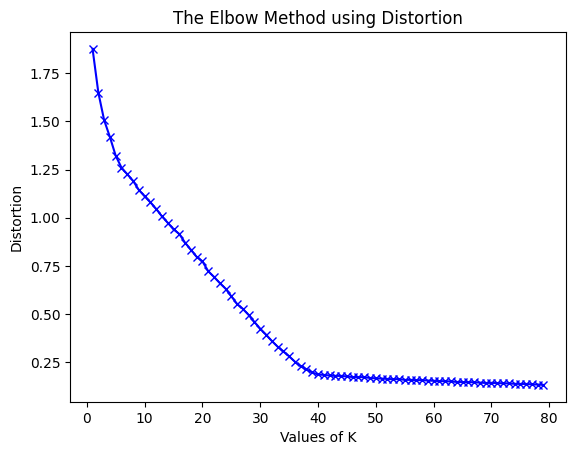

In [ ]:

distortions = []                                          # it is average of squared distances from the cluster centers of the respective clusters(typically euclidean distance metric is used)
inertias = []                                               # sum of squared distances of samples to their closest cluster center
mapping1 = {}
mapping2 = {}
K = range(1, 80)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]

# Plotting (elbow)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

**Here, it is clearly visual a sharp turn of elbow at number of cluster value = 40.**

In [ ]:
#saving this model
with open('image_class_clustering model.pkl', 'wb') as f:
    pickle.dump(kmeanModel, f)
